# Tutorial 3: DBiT-Seq Mouse Embryo RNA and Protein Multi-Omics Data

We applied COSMOS to a spatially resolved RNA-Protein multi-omics dataset. This dataset contains 1,789 spatially resolved cells from E10 mouse embryo brain regions with a joint profiling of 22 proteins and 254 genes with DBiT-seq.

The raw data can be downloaded from: 
https://figshare.com/articles/dataset/Spatial_genomics_datasets/21623148/5

The processed data is available at: https://zenodo.org/records/13932144


In [20]:
import pandas as pd
import numpy as np
import scanpy as sc
import matplotlib
import matplotlib.pyplot as plt
from umap import UMAP
import sklearn
import seaborn as sns
import h5py
# from COSMOS.cosmos import Cosmos
from COSMOS.cosmos_transformer_pe_version import Cosmos
from COSMOS.pyWNN import pyWNN 
import warnings
warnings.filterwarnings('ignore')
random_seed = 20

##  Preparation of data

### Importing the data

In [21]:
data_mat = h5py.File('./DBiT_Seq Mouse Embryo_RNA_Protein.h5', 'r')
df_data_RNA = np.array(data_mat['X_gene']).astype('float64')     # gene count matrix
df_data_protein = np.array(data_mat['X_protein']).astype('float64')  # protein count matrix
loc = np.array(data_mat['pos']).astype('float64') 
gene_names = list(data_mat['gene'])
gene_names = [gene.decode("utf-8") for gene in gene_names]
protein_names = list(data_mat['protein'])
protein_names = [protein.decode("utf-8") for protein in protein_names]
protein_names = [protein.split(".")[0] for protein in protein_names]

### Preprocessing of the data

In [22]:
adata1 = sc.AnnData(df_data_RNA, dtype="float64")
adata1.index = gene_names
sc.pp.normalize_per_cell(adata1)
sc.pp.log1p(adata1)

adata2 = sc.AnnData(df_data_protein, dtype="float64")
adata2.index = protein_names
sc.pp.log1p(adata2)


adata1.obsm['spatial'] = np.array(loc)
adata1.obs['x_pos'] = np.array(loc)[:,0]
adata1.obs['y_pos'] = np.array(loc)[:,1]


adata2.obsm['spatial'] = np.array(loc)
adata2.obs['x_pos'] = np.array(loc)[:,0]
adata2.obs['y_pos'] = np.array(loc)[:,1]

## Applying COSMOS to integrate RNA and Protein omics

In [23]:
## COSMOS training 
cosmos_comb = Cosmos(adata1=adata1,adata2=adata2)
cosmos_comb.preprocessing_data(n_neighbors = 10)
cosmos_comb.train(spatial_regularization_strength=0.05, z_dim=50, 
         lr=1e-3, wnn_epoch = 100, total_epoch=1000, max_patience_bef=10, max_patience_aft=30, min_stop=200, 
         random_seed=random_seed, gpu=0, regularization_acceleration=True, edge_subset_sz=1000000, num_heads=2, dropout=0.3, use_pe=False, pe_dim=0)
weights = cosmos_comb.weights
df_embedding = pd.DataFrame(cosmos_comb.embedding)

✓ Preprocessing complete:
  - Cells: 1789
  - Modality 1 features: 254
  - Modality 2 features: 22
  - Spatial neighbors: 10

COSMOS: Graph Transformer + Positional Encoding
Architecture:
  - Model: Graph Transformer
  - Attention heads: 2
  - Dropout: 0.3
  - Positional Encoding: ✗ Disabled
  - Output dimension: 50

Training:
  - Total epochs: 1000
  - WNN computation at epoch: 100
  - Learning rate: 0.001
  - Spatial regularization: 0.05
  - Device: cuda:0
  - Random seed: 20

Starting training...
Epoch 1/1000, Loss: 1.408896
Epoch 11/1000, Loss: 1.379830
Epoch 21/1000, Loss: 1.264316
Epoch 31/1000, Loss: 0.861625
Epoch 41/1000, Loss: 0.491292
Epoch 51/1000, Loss: 0.306261
Epoch 61/1000, Loss: 0.199982
Epoch 71/1000, Loss: 0.138500
Epoch 81/1000, Loss: 0.105480
Epoch 91/1000, Loss: 0.068793
Computing KNN distance matrices using default Scanpy implementation
Computing modality weights
Computing weighted distances for union of 200 nearest neighbors between modalities
0 out of 1789 0.00

### Clustering of COSMOS integration

In [24]:
def screen_res(df_embedding, n_cluster = 5, res_s = 0.1, res_e = 1.0, step = 0.1):
    opt_res = res_s
    opt_clusters = n_cluster
    for res in np.arange(res_s,res_e,step):
        embedding_adata = sc.AnnData(df_embedding)
        sc.pp.neighbors(embedding_adata, n_neighbors=50, use_rep='X')
        sc.tl.leiden(embedding_adata, resolution=float(res))
        clusters = list(embedding_adata.obs["leiden"])
        cluster_num = len(np.unique(clusters))
        print('res = ' + str(round(res, 2)) + ', Cluster# = ' + str(cluster_num))
        if cluster_num == n_cluster:
            opt_res = res
            opt_clusters = clusters
    print('optimal res = ' + str(round(opt_res, 2)))
    return opt_res, opt_clusters

# Screening resolution that matches the given number of clusters 
opt_res_cosmos, opt_clusters_cosmos = screen_res(df_embedding,res_s = 0.4, res_e = 0.7, step = 0.02,n_cluster = 10)

res = 0.4, Cluster# = 4
res = 0.42, Cluster# = 5
res = 0.44, Cluster# = 5
res = 0.46, Cluster# = 5
res = 0.48, Cluster# = 5
res = 0.5, Cluster# = 5
res = 0.52, Cluster# = 5
res = 0.54, Cluster# = 5
res = 0.56, Cluster# = 5
res = 0.58, Cluster# = 5
res = 0.6, Cluster# = 5
res = 0.62, Cluster# = 5
res = 0.64, Cluster# = 5
res = 0.66, Cluster# = 5
res = 0.68, Cluster# = 6
optimal res = 0.4


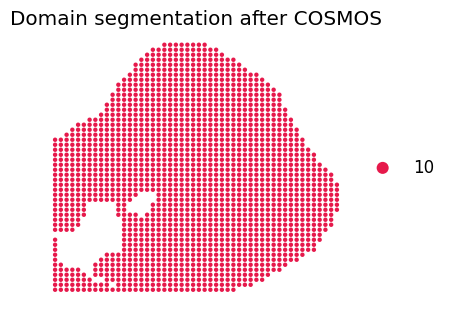

In [25]:
# Plotting figures

adata_new = adata1.copy()
adata_new.obs['Cluster_cosmos'] = opt_clusters_cosmos
adata_new.obs["Cluster_cosmos"]=adata_new.obs["Cluster_cosmos"].astype('category')

matplotlib.rcParams['font.size'] = 12.0
fig, axes = plt.subplots(1, 1, figsize=(4,3.5))
sz = 40
plot_color=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']

domains="Cluster_cosmos"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'Domain segmentation after COSMOS'
ax=sc.pl.scatter(adata_new,alpha=1,x="x_pos",y="y_pos",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')
ax.axes.invert_yaxis()
plt.show()

### UMAP visualization of COSMOS integration

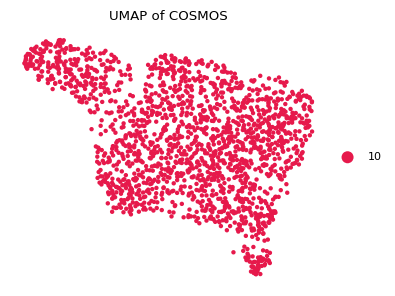

In [26]:
# UMAP visualization
umap_2d = UMAP(n_components=2, init='random', random_state=random_seed, min_dist = 0.3,n_neighbors=30)
umap_pos = umap_2d.fit_transform(df_embedding)
adata_new.obs['cosmos_umap_pos_x'] = umap_pos[:,0]
adata_new.obs['cosmos_umap_pos_y'] = umap_pos[:,1]

# Ploting figures
plot_color=['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4', '#46f0f0', '#f032e6', \
            '#bcf60c', '#fabebe', '#008080', '#e6beff', '#9a6324', '#ffd8b1', '#800000', '#aaffc3', '#808000', '#000075', '#000000', '#808080', '#ffffff', '#fffac8']
matplotlib.rcParams['font.size'] = 8.0
fig, axes = plt.subplots(1, 1, figsize=(4,3))
sz = 40
domains="Cluster_cosmos"
num_celltype=len(adata_new.obs[domains].unique())
adata_new.uns[domains+"_colors"]=list(plot_color[:num_celltype])
titles = 'UMAP of COSMOS'
ax=sc.pl.scatter(adata_new,alpha=1,x="cosmos_umap_pos_x",y="cosmos_umap_pos_y",color=domains,title=titles ,color_map=plot_color,show=False,size=sz,ax = axes)
ax.axis('off')
plt.tight_layout()
plt.show()

### Showing modality weights of two omics in COSMOS integration

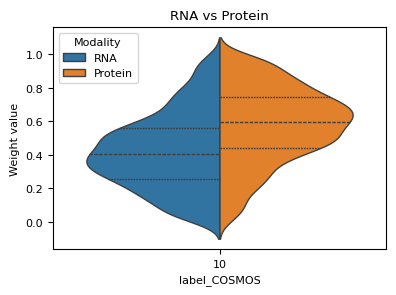

In [27]:
# 1. Retrieve the actual cluster labels directly from the AnnData object
layer_labels = adata_new.obs['Cluster_cosmos'].values
labels_uniq = np.unique(layer_labels)

# 2. Vectorized index finding (Faster and avoids the "int has no len" error)
index_all = [np.where(layer_labels == label)[0] for label in labels_uniq]

# 3. Calculate mean weights for each cluster
wghts_mean_list = []
for idx in index_all:
    # Ensure we are taking the mean across the correct axis
    wghts_mean_list.append(np.mean(weights[idx, :], axis=0))

wghts_mean = np.vstack(wghts_mean_list)
df_wghts_mean = pd.DataFrame(wghts_mean, columns=['w1','w2'], index=labels_uniq)

# 4. Define the plotting function
def plot_weight_value(alpha, label, modality1='RNA', modality2='Protein', order=None):
    df = pd.DataFrame(columns=[modality1, modality2, 'label'])  
    df[modality1], df[modality2] = alpha[:, 0], alpha[:, 1]
    df['label'] = label
    # Stack data for seaborn violinplot
    df = df.set_index('label').stack().reset_index()
    df.columns = ['label_COSMOS', 'Modality', 'Weight value']
    
    matplotlib.rcParams['font.size'] = 8.0
    fig, axes = plt.subplots(1, 1, figsize=(4,3))
    ax = sns.violinplot(data=df, x='label_COSMOS', y='Weight value', hue="Modality",
                        split=True, inner="quart", linewidth=1, orient='v', order=order)
    ax.set_title(modality1 + ' vs ' + modality2) 
    plt.tight_layout(w_pad=0.05)

# 5. Sort and Plot
df_sort_mean = df_wghts_mean.sort_values(by=['w1'])
plot_weight_value(weights, np.array(adata_new.obs['Cluster_cosmos']), order=list(df_sort_mean.index))
plt.show()